In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import pyplot as plt
from superresolution import Superresolution
from utils import get_img_paths, load_image, create_mask, plot_prediction
from model import DeeplabV3Plus
from tqdm import tqdm

In [2]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
PASCAL_ROOT = os.path.join(DATA_DIR, "VOCdevkit", "VOC2012")
IMGS_PATH = os.path.join(PASCAL_ROOT, "JPEGImages")

precomputed_dest_root = os.path.join(DATA_DIR, "precomputed_features")
if not os.path.exists(precomputed_dest_root):
    os.mkdir(precomputed_dest_root)

SEED = np.random.randint(0, 1000)
IMG_SIZE = (512, 512)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EPOCHS = 30
CLASSES = 21
RESHAPE_MASKS = True
NUM_AUG = 50
CLASS_ID = 8 # Cat class

In [3]:
def filter_by_class(img_paths, class_id, image_size=(512, 512)):
    images_dict = {}
    for img_path in img_paths:
        image_name = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = img_path.replace("JPEGImages", "SegmentationClassAug").replace("jpg", "png")
        mask = load_image(mask_path, image_size=image_size, normalize=False, is_png=True, resize_method="nearest")
        if np.any(mask == class_id):
            image = load_image(img_path, image_size=IMG_SIZE, normalize=True)
            images_dict[image_name] = image

    print(f"Valid images: {len(images_dict)} (Initial:  {len(img_paths)})")
    return images_dict

In [4]:
image_list_path = os.path.join(DATA_DIR, "augmented_file_lists", "valaug.txt")
image_paths = get_img_paths(image_list_path, IMGS_PATH)[:300]

images_dict = filter_by_class(image_paths, class_id=8)

model_no_upsample = DeeplabV3Plus(
    input_shape=(512, 512, 3),
    classes=21,
    OS=16,
    last_activation=None,
    load_weights=True,
    backbone="mobilenet",
    alpha=1.).build_model(final_upsample=False)

model_standard = DeeplabV3Plus(
    input_shape=(512, 512, 3),
    classes=21,
    OS=16,
    last_activation=None,
    load_weights=True,
    backbone="mobilenet",
    alpha=1.).build_model(final_upsample=True)

Valid images: 26 (Initial:  300)


# Save standard output for comparison

In [5]:
def get_prediction(model, input_image):

    prediction = model.predict(input_image[tf.newaxis, ...])
    mask = create_mask(prediction[0])

    return mask

def save_standard_output(image_dict, model, standard_out_folder, filter_class_id=None):
    standard_masks = {}
    if not os.path.exists(standard_out_folder):
        os.mkdir(standard_out_folder)

    for key in image_dict:
        standard_mask = get_prediction(model, image_dict[key])
        if filter_class_id is not None:
            standard_mask = tf.where(standard_mask == filter_class_id, standard_mask, 0)
        tf.keras.utils.save_img(f"{standard_out_folder}/{key}.png", standard_mask, scale=False)
        standard_masks[key] = standard_mask
    return standard_masks

In [6]:
standard_out_folder = os.path.join(DATA_DIR, "standard_output")
standard_masks = save_standard_output(images_dict, model_standard, standard_out_folder, filter_class_id=CLASS_ID)

# Precompute Augmented Output Features

In [7]:
def augment_images(batched_images, angles, shifts):

    rotated_images = tfa.image.rotate(batched_images, angles, interpolation="bilinear")
    translated_images = tfa.image.translate(rotated_images, shifts, interpolation="bilinear")

    return translated_images


def save_augmented_features(model, images_array, dest_folder, filter_class_id=None):
    if not os.path.exists(dest_folder):
        os.mkdir(dest_folder)

    predictions = model.predict(images_array, batch_size=2)

    for i, prediction in enumerate(predictions):
        mask = prediction[:, :, CLASS_ID]
        tf.keras.utils.save_img(f"{dest_folder}/{i}.png", mask[:, :, tf.newaxis], scale=False)

    return predictions


def precompute_augmented_features(images_dict, dest_root_folder, model, class_id=None, num_aug=100, angle_max=0.5, shift_max=30):
    for key in tqdm(images_dict):
        batched_image = tf.tile(tf.expand_dims(images_dict[key], axis=0), [num_aug, 1, 1, 1])  # Size [num_aug, 512, 512, 3]
        angles = np.random.uniform(-angle_max, angle_max, num_aug)
        shifts = np.random.uniform(-shift_max, shift_max, (num_aug, 2))
        # First sample is not augmented
        angles[0] = 0
        shifts[0] = np.array([0, 0])
        angles = angles.astype("float32")
        shifts = shifts.astype("float32")

        augmented_images = augment_images(batched_image, angles, shifts)

        dest_folder = os.path.join(dest_root_folder, key)

        save_augmented_features(model, augmented_images, dest_folder=dest_folder, filter_class_id=class_id)
        np.save(os.path.join(dest_folder, f"{key}_angles"), angles)
        np.save(os.path.join(dest_folder, f"{key}_shifts"), shifts)

In [8]:
angle_max = 0.5  # in radians
shift_max = 30

precompute_augmented_features(images_dict, precomputed_dest_root, model_no_upsample, class_id=CLASS_ID, num_aug=NUM_AUG,
                              angle_max=angle_max, shift_max=shift_max)

100%|██████████| 26/26 [01:54<00:00,  4.41s/it]


# Compute Super-Resolution Output

In [24]:
def load_images(img_folder):
    images = []
    # Sort images based on their filename which is an integer indicating the augmented copy number
    image_list = sorted([name.replace(".png", "") for name in os.listdir(img_folder) if ".npy" not in name], key=int)

    for img_name in image_list:
        if ".npy" in img_name:
            continue
        image = load_image(os.path.join(img_folder, f"{img_name}.png"), normalize=False, is_png=True)
        images.append(image)

    return images


def get_precomputed_folders_path(root_dir, num_aug=100):
    valid_folders = []
    for path in os.listdir(root_dir):
        full_path = os.path.join(root_dir, path)
        if len(os.listdir(full_path)) == (num_aug + 2):
            valid_folders.append(full_path)
        else:
            print(f"Skipped folder named {path} as it is not valid")

    return valid_folders


def compute_save_final_output(superresolution_obj, precomputed_features_folders, output_folder):

    superres_masks = {}

    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    for folder in tqdm(precomputed_features_folders):
        augmented_images = tf.stack(load_images(folder))
        augmented_images = tf.cast(augmented_images, tf.float32)

        base_name = os.path.basename(os.path.normpath(folder))
        angles = np.load(os.path.join(folder, f"{base_name}_angles.npy"))
        shifts = np.load(os.path.join(folder, f"{base_name}_shifts.npy"))
        target_image = superresolution_obj.compute_output(augmented_images, angles, shifts)

        #TODO: handle image scaling
        tf.keras.utils.save_img(f"{output_folder}/{base_name}.png", target_image[0], scale=False)

        superres_masks[base_name] = target_image[0]

    return superres_masks

In [ ]:
# super resolution parameters
learning_rate = 1e-4
lambda_eng = 0.0001 * NUM_AUG
lambda_tv = 0.002 * NUM_AUG
num_iter = 400

superresolution = Superresolution(
    lambda_tv=lambda_tv,
    lambda_eng=lambda_eng,
    num_iter=num_iter,
    num_aug=NUM_AUG,
    learning_rate=learning_rate
)

precomputed_root_dir = os.path.join(DATA_DIR, "precomputed_features")
output_folder = os.path.join(DATA_DIR, "superres_output")

precomputed_folders_path = get_precomputed_folders_path(precomputed_root_dir, num_aug=NUM_AUG)
superres_masks = compute_save_final_output(superresolution, precomputed_folders_path, output_folder)

# Evaluation

In [11]:
def Mean_IOU(y_true, y_pred):
    nb_classes = 21  # TODO: set this as a parameter
    ious = []
    for i in range(0, nb_classes):  # exclude last label (void)
        y_true_squeeze = tf.squeeze(y_true)
        y_pred_squeeze = tf.squeeze(y_pred)
        true_labels = tf.equal(y_true_squeeze, i)
        pred_labels = tf.equal(y_pred_squeeze, i)
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)

        iou = tf.reduce_sum(inter) / tf.reduce_sum(union)
        # returns average IoU of the same objects
        ious.append(iou)

    ious = tf.stack(ious)
    legal_labels = ~tf.math.is_nan(ious)
    ious = tf.gather(ious, indices=tf.where(legal_labels))
    return tf.reduce_mean(ious)


def evaluate_IOU(true_mask, standard_mask, superres_mask, img_size=(512, 512)):
    true_mask = tf.reshape(true_mask, (img_size[0] * img_size[1], 1))
    standard_mask = tf.reshape(standard_mask, (img_size[0] * img_size[1], 1))
    superres_mask = tf.reshape(superres_mask, (img_size[0] * img_size[1], 1))

    standard_IOU = Mean_IOU(true_mask, standard_mask)
    superres_IOU = Mean_IOU(true_mask, superres_mask)

    return standard_IOU.numpy(), superres_IOU.numpy()

def compare_results(image_dict, standard_dict, superres_dict, image_size=(512, 512)):
    standard_IOUs = []
    superres_IOUs = []

    for key in image_dict:
        true_mask_path = os.path.join(DATA_DIR, "VOCdevkit/VOC2012/SegmentationClassAug", f"{key}.png")
        true_mask = load_image(true_mask_path, image_size=image_size, normalize=False,
                               is_png=True, resize_method="nearest")

        standard_mask = standard_dict[key]
        superres_image = superres_dict[key]

        standard_IOU, superres_IOU = evaluate_IOU(true_mask, standard_mask, superres_image, img_size=image_size)
        standard_IOUs.append(standard_IOU)
        superres_IOUs.append(superres_IOU)
        print(f"IOUs for image {key} - Standard: {str(standard_IOU)}, Superres: {str(superres_IOU)}")

    return standard_IOUs, superres_IOUs

In [12]:
standard_IOUs, superres_IOUs = compare_results(images_dict, standard_masks, superres_masks, image_size=IMG_SIZE)

IOUs for image 2008_002152 - Standard: 0.9110138138264214, Superres: 0.0
IOUs for image 2007_008815 - Standard: 0.8472112661905867, Superres: 0.0
IOUs for image 2008_000345 - Standard: 0.934832400627329, Superres: 0.0
IOUs for image 2010_005421 - Standard: 0.8871441940807192, Superres: 0.0
IOUs for image 2010_002531 - Standard: 0.30021452457568304, Superres: 0.0
IOUs for image 2010_001351 - Standard: 0.7334663543136135, Superres: 0.0
IOUs for image 2010_002025 - Standard: 0.926450448181216, Superres: 0.0
IOUs for image 2011_000661 - Standard: 0.27993569846269833, Superres: 0.0
IOUs for image 2009_000080 - Standard: 0.9110570011403276, Superres: 0.0
IOUs for image 2010_000724 - Standard: 0.7763879510555349, Superres: 0.0
IOUs for image 2007_009346 - Standard: 0.9174817197611816, Superres: 0.0
IOUs for image 2010_001913 - Standard: 0.851644657763357, Superres: 0.0
IOUs for image 2011_001601 - Standard: 0.30248268586111254, Superres: 0.0
IOUs for image 2010_002693 - Standard: 0.3777695974

In [13]:
np.mean(standard_IOUs)

0.6825854244744621

# Tests

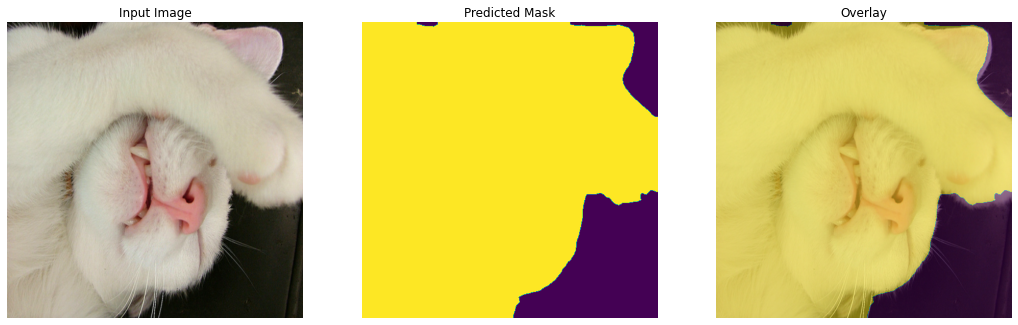

In [26]:
sample_key = random.choice(list(images_dict.keys()))
sample_image = images_dict[sample_key]
sample_standard = standard_masks[sample_key]
sample_superres = superres_masks[sample_key]

true_mask_path = os.path.join(DATA_DIR, "VOCdevkit/VOC2012/SegmentationClassAug", f"{sample_key}.png")
true_mask = load_image(true_mask_path, image_size=IMG_SIZE, normalize=False, is_png=True, resize_method="nearest")

plot_prediction([sample_image, sample_standard], only_prediction=True, show_overlay=True)

In [27]:
def plot_standard_superres(input_image, standard_mask, superres_mask):
    plt.figure(figsize=(18, 18))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Sandard predicted Mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(standard_mask), alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Superresolution Mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(superres_mask), alpha=0.5)
    plt.axis('off')

    plt.show()


def plot_histogram(image):
    plt.figure(figsize=(18, 18))
    vals = image.flatten()
    b, bins, patches = plt.hist(vals, 255)
    plt.show()


def print_labels(masks):
    title = ["Standard Labels: ", "Superres Labels: "]
    for i in range(2):
        values, count = np.unique(masks[i], return_counts=True)
        print(title[i] + str(dict(zip(values, count))))

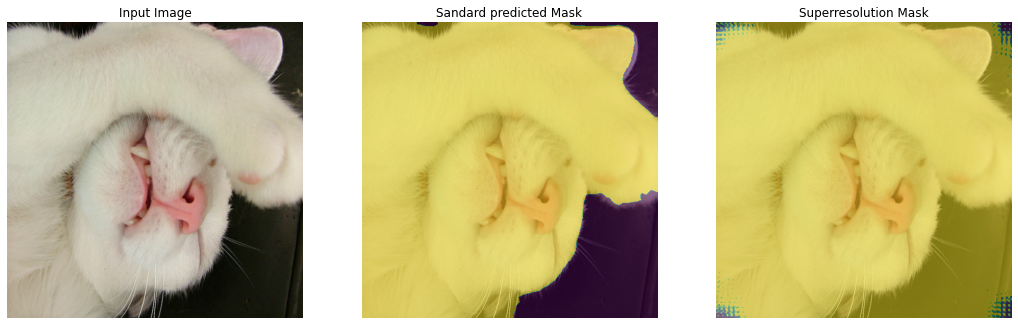

In [28]:
plot_standard_superres(sample_image, sample_standard, sample_superres)

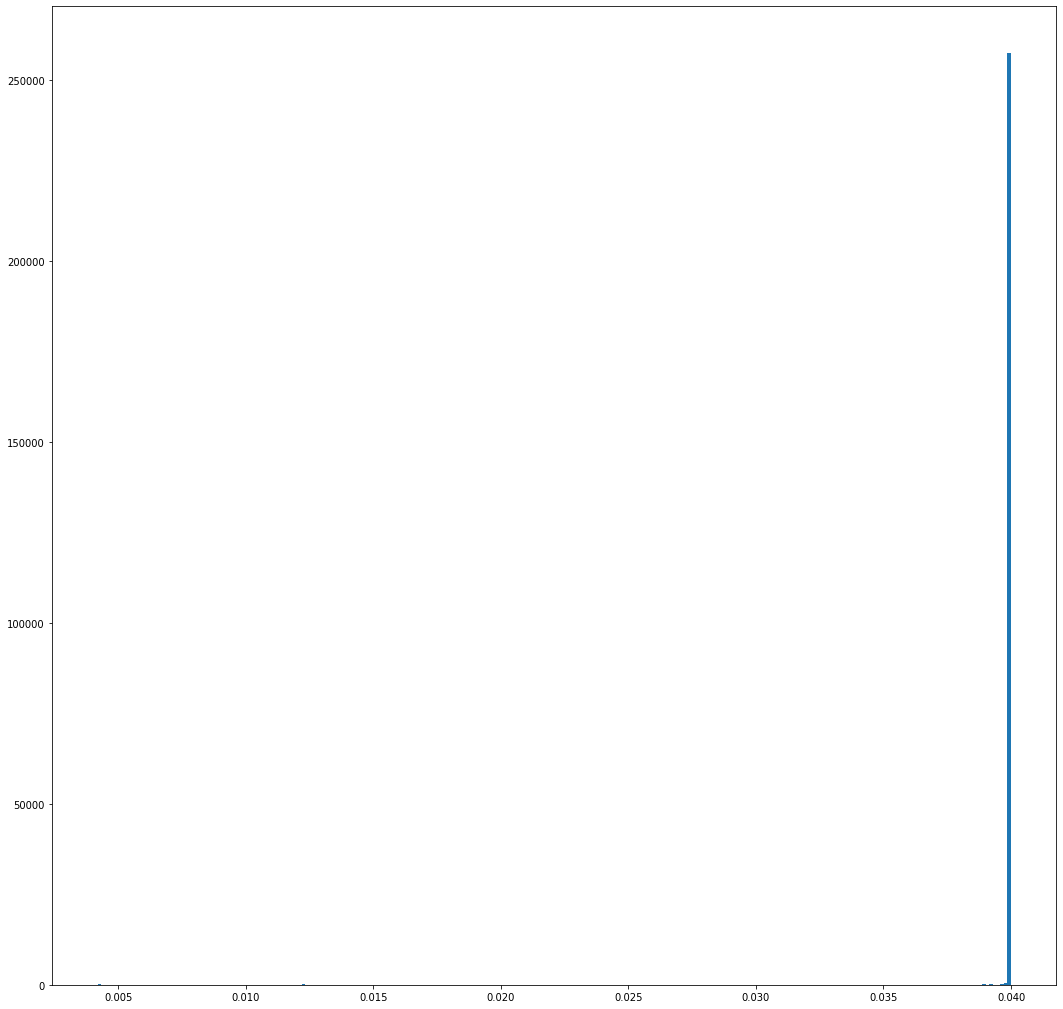

In [29]:
superres_numpy = sample_superres.numpy()
plot_histogram(superres_numpy)

In [30]:
sample_th = np.max(superres_numpy) * 0.15
th_mask = tf.where(sample_superres > sample_th, sample_superres, 0).numpy()
th_mask_class = tf.where(sample_superres > sample_th, CLASS_ID, 0).numpy()

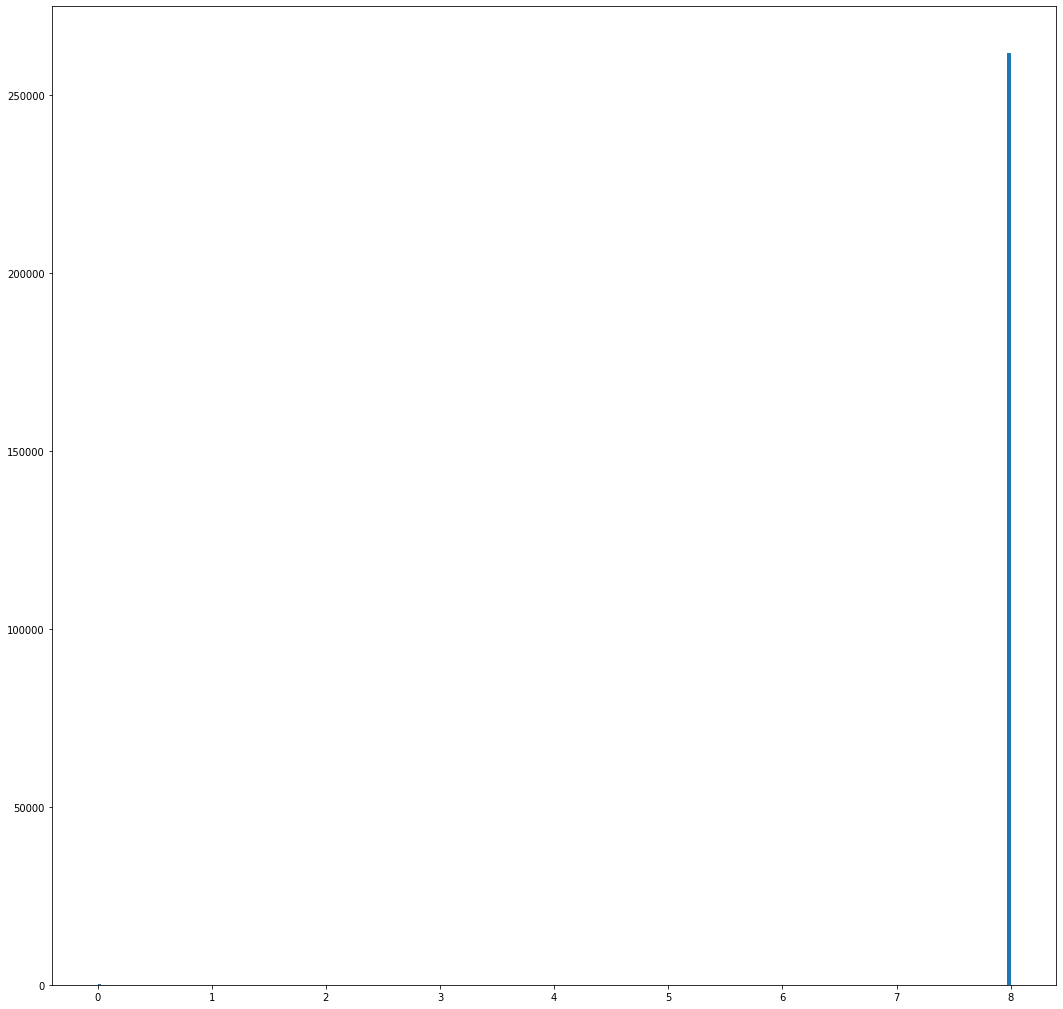

In [31]:
plot_histogram(th_mask_class)

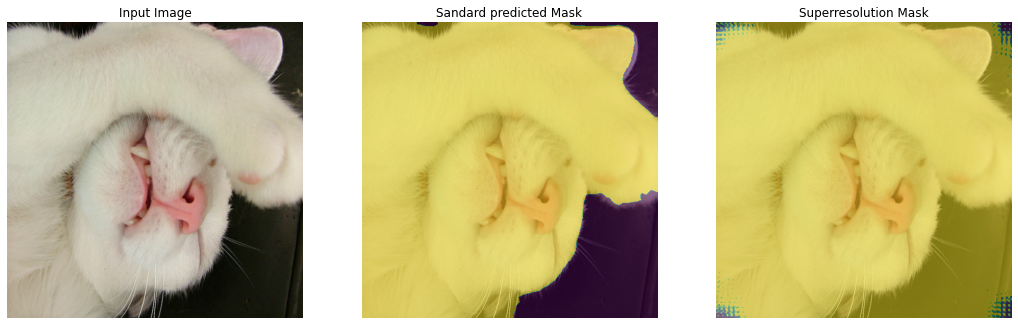

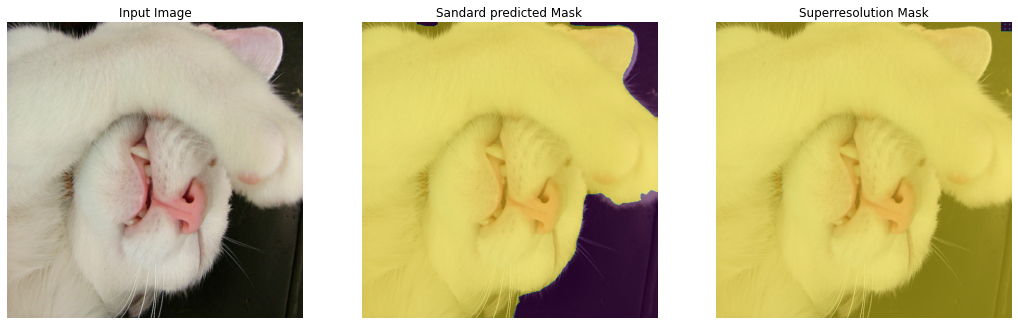

In [32]:
plot_standard_superres(sample_image, sample_standard, sample_superres)
plot_standard_superres(sample_image, sample_standard, th_mask_class)

In [33]:
evaluate_IOU(true_mask, sample_standard, th_mask_class)

(0.899345505255471, 0.40692208095129984)

In [34]:
test_scaled = ((superres_numpy - superres_numpy.min()) * (1/(superres_numpy.max() - superres_numpy.min()) * 255)).astype('uint8')

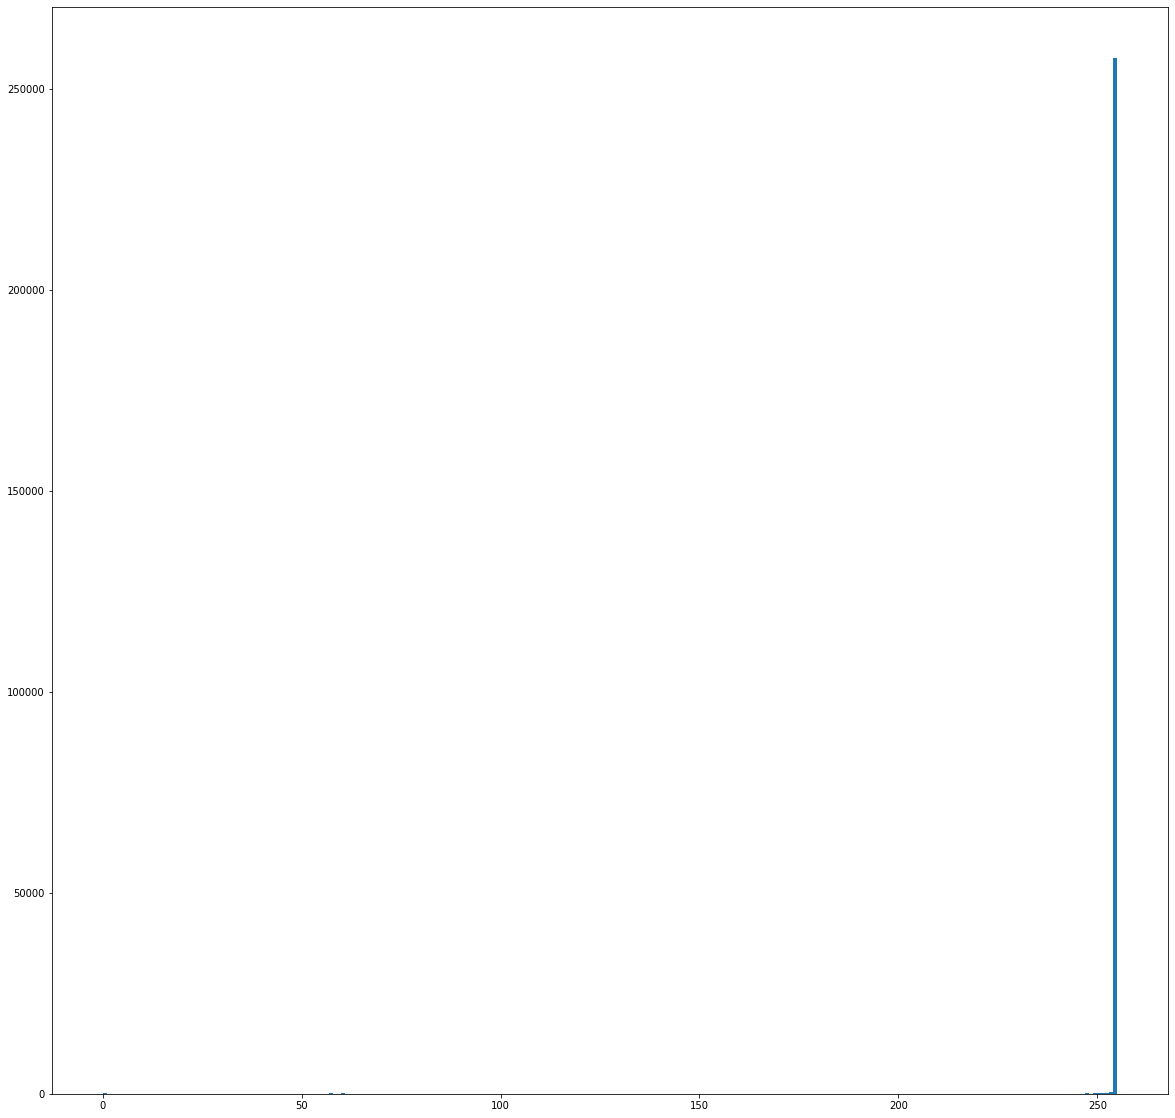

In [35]:
plt.figure(figsize=(20, 20))
vals = test_scaled.flatten()
b, bins, patches = plt.hist(vals, 255)
plt.show()